# Carga de datos

In [2]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
#from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
#from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
ubi = './data/ODScat_345.xlsx'

In [4]:
df_ods = pd.read_excel(ubi)

# Entendimiento de los datos

## 1.1 Perfilamiento de datos

In [7]:
df_ods.shape

(4049, 2)

Se evidencion que hay 4049 opiniones sobre problematicas relacionadas con los ODS

In [9]:
df_ods.sample(5)

,Textos_espanol,sdg
3202,"Por lo tanto, necesitan desarrollar fuertes ví...",4
2667,"Prensa feminista, 2007), pág. 212. Comenzó a e...",5
1374,"El maestro de preescolar, el maestro de primer...",4
1106,Aquellos que hablan un idioma europeo tienen p...,4
4022,"Además, el plan no solo cubre al ejército cana...",5


La informacion cuenta con dos columnas, la primera Textos_espanol contiene el texto con la opinion del ciudadano, la segunda es el numero de ODS que le corresponde (columna que debemos predecir)

In [11]:
df_ods['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

In [12]:
longitudes = df_ods['Textos_espanol'].apply(len)
df_ods['text_length'] = longitudes
longitudes.to_frame()

,Textos_espanol
0,944
1,476
2,1207
3,1090
4,895
...,...
4044,822
4045,514
4046,445
4047,1017


In [13]:
longitudes.describe().to_frame()

,Textos_espanol
count,4049.000000
mean,699.632502
std,228.988965
min,294.000000
25%,531.000000
50%,657.000000
75%,827.000000
max,1513.000000


In [14]:
# Palabras mas comunes
spanish_stop_words = stopwords.words('spanish')

vectorizer = CountVectorizer(stop_words=spanish_stop_words)
word_count_matrix = vectorizer.fit_transform(df_ods['Textos_espanol'])
word_counts = np.asarray(word_count_matrix.sum(axis=0)).flatten()
word_frequencies = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts})
word_frequencies.sort_values(by='count', ascending=False).head(20)

,word,count
13192,mujeres,3028
17494,salud,1639
9722,género,1523
7089,educación,1460
14503,países,1410
2297,atención,1270
13864,ocde,992
8141,estudiantes,977
17832,servicios,891
16000,pueden,845


In [15]:
# Bigramas mas comunes
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=spanish_stop_words)
bigram_count_matrix = bigram_vectorizer.fit_transform(df_ods['Textos_espanol'])
bigram_counts = np.asarray(bigram_count_matrix.sum(axis=0)).flatten()
bigram_frequencies = pd.DataFrame({'bigram': bigram_vectorizer.get_feature_names_out(), 'count': bigram_counts})
bigram_frequencies.sort_values(by='count', ascending=False).head(20)


,bigram,count
82663,igualdad género,332
17624,atención primaria,307
145847,salud mental,298
119839,países ocde,268
102415,mercado laboral,204
81083,hombres mujeres,188
106165,mujeres hombres,186
149867,si bien,164
17571,atención médica,161
54188,educación superior,157


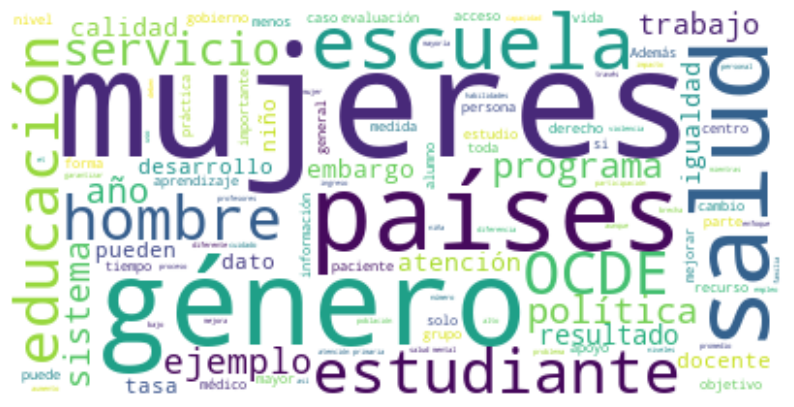

In [16]:
# Análisis 1: Nube de palabras (Word Cloud)
wordcloud = WordCloud(stopwords=spanish_stop_words, background_color="white", max_words=100).generate(" ".join(df_ods['Textos_espanol']))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

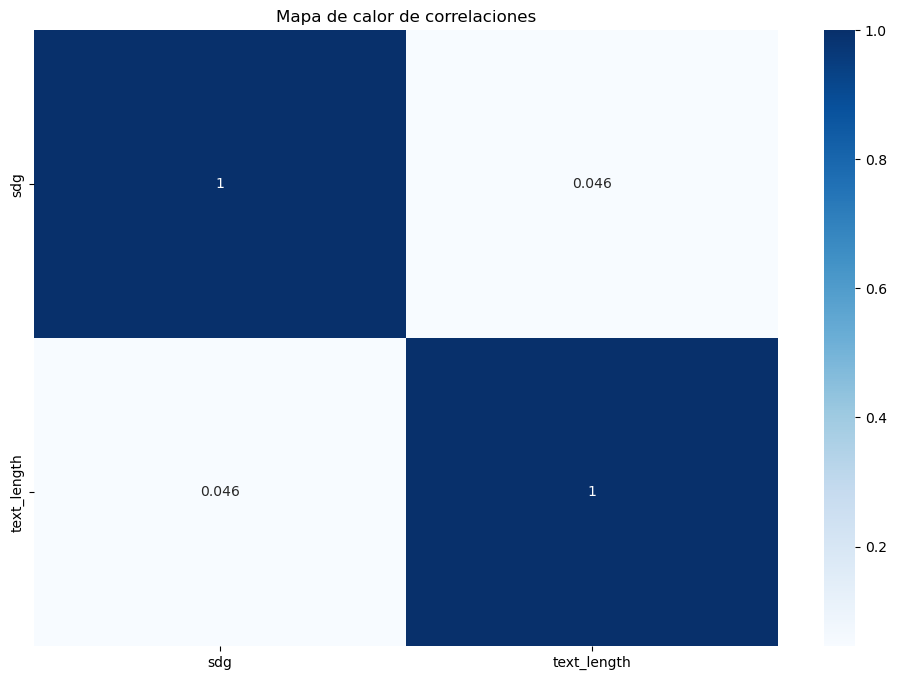

In [17]:
# Análisis 2: Correlación entre la longitud de los textos y las clases
class_length_corr = df_ods[['sdg', 'text_length']].corr()


# Análisis de correlación entre variables numéricas para buscar dependencias
datos_numericos = df_ods.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(datos_numericos.corr(),  cmap="Blues", annot=True)
plt.title('Mapa de calor de correlaciones')
plt.show()

## 1.2 Calidad de datos

### 1.2.1 Completitud

In [20]:
# Porcentaje de valores nulos por columna
((df_ods.isnull().sum()/df_ods.shape[0])).sort_values(ascending=False)

Textos_espanol    0.0
sdg               0.0
text_length       0.0
dtype: float64

### 1.2.2 Unicidad

In [22]:
df_ods.duplicated(keep = False).sum()

0

### 1.2.3 Consistencia

In [24]:
df_ods.dtypes

Textos_espanol    object
sdg                int64
text_length        int64
dtype: object

### 1.2.4 Validez

In [26]:
df_ods["sdg"].value_counts(dropna=False)

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

# Preparacion de datos

Resolver problemas de codificacion

In [29]:
# Create a mapping of UTF-8 misinterpreted characters to their correct ANSI equivalent
utf8_to_ansi_map = {
    'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
    'Ã±': 'ñ', 'ÃÁ': 'Á', 'Ã‰': 'É', 'ÃÍ': 'Í', 'ÃÓ': 'Ó',
    'ÃÚ': 'Ú', 'Ã‘': 'Ñ', 'Â¿': '¿', 'Â¡': '¡'
}

# Function to replace UTF-8 misinterpreted characters with ANSI equivalents
def replace_utf8_with_ansi(text):
    for utf8_char, ansi_char in utf8_to_ansi_map.items():
        text = text.replace(utf8_char, ansi_char)
    return text

df_manipulado = df_ods.copy()
# Apply the fix to the problematic column
df_manipulado['Textos_espanol'] = df_ods['Textos_espanol'].apply(replace_utf8_with_ansi)
df_manipulado.sample(5)


,Textos_espanol,sdg,text_length
530,Las habilidades sociales son un determinante c...,3,599
847,"En el Reino Unido, los ADE pueden representar ...",3,594
15,Estas estaciones cuentan con asistentes médico...,3,547
4037,A pesar de que las mujeres están en el mercado...,5,773
1229,Se consideró que el éxito de las reformas al p...,4,474


Convertir en tokens

In [31]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in spanish_stop_words]
    return ' '.join(tokens)


df_manipulado['processed_text'] = df_manipulado['Textos_espanol'].apply(preprocess_text)
df_manipulado

,Textos_espanol,sdg,text_length,processed_text
0,"Por ejemplo, el número de consultas externas d...",3,944,ejemplo número consultas externas especialista...
1,"En 2007, el gobierno central financió directam...",3,476,2007 gobierno central financió directamente so...
2,"Claramente, hay muchos otros factores en juego...",3,1207,claramente factores juego particular variedad ...
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,ejemplo australiano victoria creó agencia prom...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,consumo anual alcohol estima litros año hombre...
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,822,ello identificará cuestiones género destacadas...
4045,La participación de las mujeres en roles de li...,5,514,participación mujeres roles liderazgo dentro l...
4046,"Según el WEF, según las tendencias de 2016, po...",5,445,según wef según tendencias 2016 podría cerrars...
4047,"Sirve como recurso y foro para las agencias, c...",5,1017,sirve recurso foro agencias objetivo lograr en...


Lemalizacion

In [33]:
# 4. Transform to vectors: Using TF-IDF for text representation

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_manipulado['processed_text'])


In [34]:
y = df_ods['sdg']

In [35]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = rf_model.predict(X_test)

# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)

0.9703703703703703
              precision    recall  f1-score   support

       ODS 3       0.98      0.98      0.98       250
       ODS 4       0.96      0.97      0.97       268
       ODS 5       0.98      0.96      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



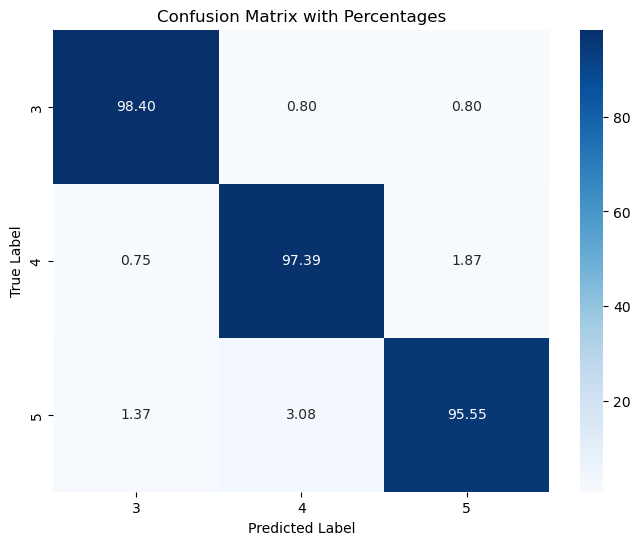

In [36]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.title('Confusion Matrix with Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [37]:
# 4. Transform to vectors: Using TF-IDF for text representation

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_manipulado['processed_text'])
y = df_ods['sdg']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)  # Default to 3 neighbors for now
knn.fit(X_train, y_train)

# Predict the target for the test set
y_pred = knn.predict(X_test)

# Evaluate the model using a classification report
classification_report_result = classification_report(y_test, y_pred)

# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)


0.9395061728395062
              precision    recall  f1-score   support

       ODS 3       0.93      0.93      0.93       250
       ODS 4       0.94      0.95      0.95       268
       ODS 5       0.94      0.93      0.94       292

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



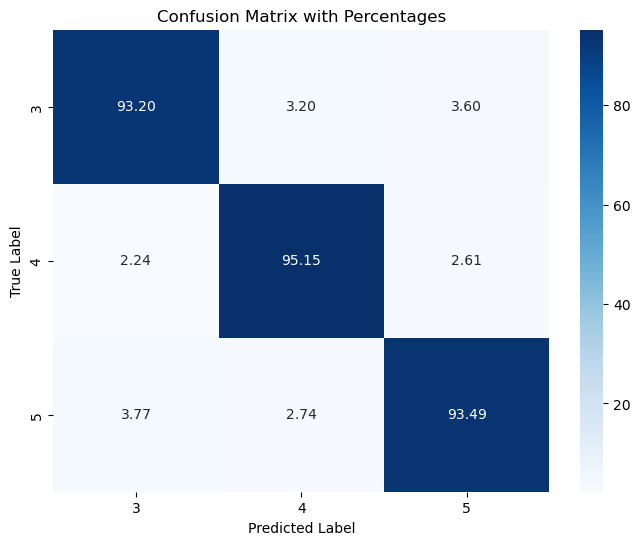

In [40]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[3, 4, 5], yticklabels=[3, 4, 5])
plt.title('Confusion Matrix with Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [41]:
# 4. Transform to vectors: Using TF-IDF for text representation

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_manipulado['processed_text'])
y = df_ods['sdg']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

y_pred = cart_model.predict(X_test)
# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ODS 3', 'ODS 4', 'ODS 5'])
print(accuracy)
print(report)

0.9246913580246914
              precision    recall  f1-score   support

       ODS 3       0.89      0.91      0.90       250
       ODS 4       0.94      0.91      0.92       268
       ODS 5       0.94      0.95      0.95       292

    accuracy                           0.92       810
   macro avg       0.92      0.92      0.92       810
weighted avg       0.92      0.92      0.92       810

